# <font color=darkcyan>  Kernel based regression and random forests </font>

### <font color=darkorange>  1. Independent simulated data</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
import pandas as pd

In [2]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=2) 

In [3]:
# function to sample a dataset - linear observation model
def sample_data_iid_linear(alpha,sigmay,n,d):
    X       = np.random.uniform(0,2*np.pi,[n,d])
    Y       = np.zeros(n)
    eta     = np.random.normal(loc=0,scale=1,size = n)
    Y[0]    = np.sum(np.cos(X[0,:])) + sigmay*eta[0]
    for k in range(1,n):
        Y[k]   = np.sum(alpha*X[k,:]) + sigmay*eta[k]
    return X, Y

In [4]:
# function to sample a dataset - nonlinear observation model
def sample_data_iid_signal(sigmay,n,d):
    X       = np.random.uniform(0,2*np.pi,[n,d])
    Y       = np.zeros(n)
    eta     = np.random.normal(loc=0,scale=1,size = n)
    Y[0]    = np.sum(np.cos(X[0,:])) + sigmay*eta[0]
    for k in range(1,n):
        Y[k]   = np.sum(np.cos(X[k,:])) + sigmay*eta[k]
    return X, Y

In [5]:
# set parameters
n_train = 1000
n_test = 100
d = 2
sigmay = 0.1 
true_alpha =  multivariate_normal(np.zeros(d), np.eye(d))
true_alpha

array([1.08, 0.53])

In [6]:
# sample data  
X_train, Y_train = sample_data_iid_linear(true_alpha,sigmay,n_train,d)
X_test, Y_test = sample_data_iid_linear(true_alpha,sigmay,n_test,d)

#### <font color=darkred>  Linear regression for a simulated data set </font>

It is assumed that for all $1\leqslant i \leqslant n$, 

$$
Y_i = X^T_i \beta_{\star} + \varepsilon_i\,,
$$

where the $(\varepsilon_i)_{1\leqslant i\leqslant n}$ are i.i.d. random variables in $\mathbb{R}^d$, $X_i\in\mathbb{R}^d$ and $\beta_{\star}$ is an unknown vector in $\mathbb{R}^d$. Let $Y\in\mathbb{R}^d$ (resp. $\varepsilon\in\mathbb{R}^d$)  be the random vector such that  for all $1\leqslant i \leqslant n$, the $i$-th component of $Y$ (resp. $\varepsilon$) is $Y_i$ (resp. $\varepsilon_i$) and $X\in\mathbb{R}^{n\times d}$ the matrix with line $i$ equal to $X^T_i$. The model is then written

$$
Y = X \beta_{\star} + \varepsilon\,.
$$

In this section, it is assumed that $\mathbb{E}[\varepsilon] = 0$ and $\mathbb{E}[\varepsilon \varepsilon^T] = \sigma_{\star}^2 I_n$. The penalized least squares estimate of $\beta_{\star}$ is defined as a solution to

$$
\widehat \beta_n\in  \mathrm{argmin}_{\beta\in\mathbb{R}^d}\,\left( \|Y - X\beta\|_2^2 + \lambda \|\beta\|_2^2\right)\,.
$$

where $\lambda>0$.

<font color=darkred> Explain why the loss function is penalized (blackboard) </font>

The matrix $X^TX + \lambda I_n$ is definite positive for all $\lambda>0$ as for all $u\in\mathbb{R}^d$,

$$
u^T(X^TX + \lambda I_n)u = \|Xu\|_2^2 + \lambda \|u\|_2^2\,,
$$

which is positive for all $u\neq 0$. 

Therefore,  the matrix $X^TX + \lambda I_n$ is invertible for all $\lambda>0$. Using that for all $\beta>0$,

$$
\nabla \left(\|Y - X\beta\|_2^2 + \lambda \|\beta\|_2^2\right) = 2X^TX\beta - 2X^TY +  2\lambda\beta = 2\left\{\left(X^TX + \lambda I_d\right)\beta -X^TY\right\}\,.
$$

Therefore,

$$
\widehat \beta_n = \left(X^TX + \lambda I_d\right)^{-1}X^TY\,.
$$

<font color=darkred> Prove that the bias is given by (blackboard)
$$
\mathbb{E}[\widehat \beta_n] - \beta_* = - \lambda(X^TX + \lambda I_d)^{-1}\beta_*\,.
$$</font>

Note first that $\mathbb{E}[Y] = X\beta_*$ which yields

$$
\mathbb{E}[\widehat \beta_n] = \left(X^TX + \lambda I_d\right)^{-1}X^TX\beta_*
$$

and

$$
\mathbb{E}[\widehat \beta_n] - \beta_* = \left(X^TX + \lambda I_d\right)^{-1}X^TX\beta_* - \beta_* = \left(X^TX + \lambda I_d\right)^{-1}\left(X^TX - \left(X^TX + \lambda I_d\right)\right)\beta_* = - \lambda(X^TX + \lambda I_d)^{-1}\beta_*\,.
$$

<font color=darkred>Prove that the variance is given by (blackboard)
$$
\mathbb{V}[\widehat \beta_n] = \sigma_\star^2(X^TX + \lambda I_d)^{-2}X^TX\,.
$$</font>

By definition of $\widehat\beta_n$,

$$
\mathbb{V}[\widehat \beta_n] = \left(X^TX + \lambda I_d\right)^{-1}X^T\mathbb{V}[Y]X\left(X^TX + \lambda I_d\right)^{-1} = \sigma_*^2\left(X^TX + \lambda I_d\right)^{-1}X^TX\left(X^TX + \lambda I_d\right)^{-1}\,,
$$

since $\mathbb{V}[Y] = \sigma_*^2 I_n$. Let $\lambda_1,\ldots,\lambda_d\geqslant 0$ be the eignevalues of $X^TX$. Then, there exits an orthogonal matrix $P$, such that

$$
X^TX = P^{-1}\Delta P \quad\mathrm{and}\quad X^TX + \lambda I_d = P^{-1}\tilde\Delta P\,,
$$

where $\Delta = \mathrm{diag}(\lambda_1,\ldots,\lambda_d)$ and $\tilde\Delta = \mathrm{diag}(\lambda_1 + \lambda,\ldots,\lambda_d+\lambda)$.

$$
\left(X^TX + \lambda I_d\right)^{-1}X^TX\left(X^TX + \lambda I_d\right)^{-1} = P^{-1}\tilde\Delta^{-1} PP^{-1}\Delta PP^{-1}\tilde\Delta^{-1} P = P^{-1}\tilde\Delta^{-2}PP^{-1}\Delta P = \sigma_\star^2(X^TX + \lambda I_d)^{-2}X^TX\,.
$$

In [7]:
linear_ridge_model = Ridge()
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,1, 2, 3, 4, 5]}
ridge_regressor = GridSearchCV(linear_ridge_model, parameters,scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, Y_train)
ridge_regressor.best_params_
ridge_regressor.best_score_

-0.06089642533997056

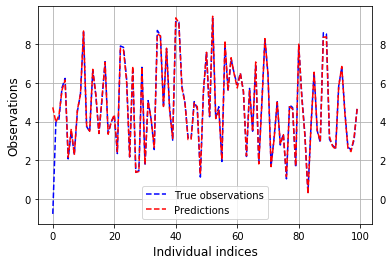

In [8]:
# plot results
Y_pred_linear = ridge_regressor.predict(X_test)
plt.plot(Y_test,linestyle = "dashed",color="blue", label= "True observations")
plt.plot(Y_pred_linear,linestyle = "dashed",color="red", label="Predictions")
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Individual indices', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

In [9]:
# sample data  
X_train, Y_train = sample_data_iid_signal(sigmay,n_train,d)
X_test, Y_test = sample_data_iid_signal(sigmay,n_test,d)

In [10]:
linear_ridge_model = Ridge()
parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,1, 2, 3, 4, 5]}
ridge_regressor = GridSearchCV(linear_ridge_model, parameters,scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, Y_train)
ridge_regressor.best_params_
ridge_regressor.best_score_
ridge_regressor.cv_results_

{'mean_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'std_fit_time': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ]),
 'mean_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'std_score_time': array([0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 'param_alpha': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1e-05},
  {'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 2},
  {'alpha': 3},
  {'alpha': 4},
  {'alpha': 5}],
 'split0_test_score': array([-1.02, -1.02, -1.02, -1.02, -1.02, -1.02, -1.02, -1.02, -1.02,
        -1.02]),
 'split1_test_score': array([-0.96, -0.96, -0.96, -0.96, -0.96, -0.96, -0.96, -0.96, -0.96,
        -0.96]),
 'split2_test_score': array([-1.02, 

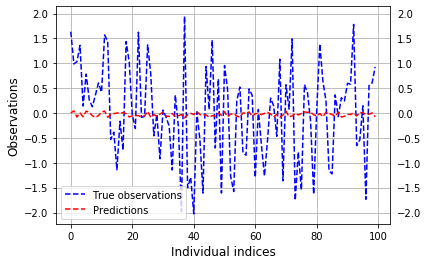

In [11]:
# plot results
Y_pred_linear = ridge_regressor.predict(X_test)
plt.plot(Y_test,linestyle = "dashed",color="blue", label= "True observations")
plt.plot(Y_pred_linear,linestyle = "dashed",color="red", label="Predictions")
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Individual indices', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

#### <font color=darkred>  Kernel regression for a simulated data set </font>

A function $k:\mathbb{R}^d\times\mathbb{R}^d:\to \mathbb{R}$ is said to be a positive semi-definite kernel if and only if it is symmetric and if for all $n\geqslant 1$, $(x_1,\ldots,x_n)\in(\mathbb{R}^d)^n$ and all $(a_1,\ldots,a_n)\in\mathbb{R}^n$,
$$
\sum_{1\leqslant i,j\leqslant n}a_ia_jk(x_i,x_j) \geqslant 0\,.
$$

The following functions, defined on $\mathbb{R}^d\times\mathbb{R}^d$, are positive semi-definite kernels:

$$
k:(x,y)\mapsto x^Ty \quad\mathrm{and}\quad k:(x,y)\mapsto \mathrm{exp}\left(-\|x-y\|^2/(2\sigma^2\right)\,,\; \sigma>0\,.
$$


Let $\mathcal{F}$ be a Hilbert space of functions $f:\mathbb{R}^d\to\mathbb{R}$. A symmetric function $k:\mathbb{R}^d\times\mathbb{R}^d:\to \mathbb{R}$ is said to be a reproducing kernel of $\mathcal{F}$ if and only if:

1. for all $x\in\mathbb{R}^d$, $k(x,\cdot)\in\mathcal{F}$ ; 

2. for all $x\in\mathbb{R}^d$ and all $f\in\mathcal{F}$, $\langle f; k(x,\cdot)\rangle_\mathcal{F} = f(x)$ . 

The space $\mathcal{F}$ is said to be a reproducing kernel Hilbert space with kernel $k$.



Let $k:\mathbb{R}^d\times\mathbb{R}^d:\to \mathbb{R}$ be a positive definite kernel and $\mathcal{F}$ the RKHS with kernel $k$. Then (see previous session), 

$$
\widehat f^n_{\mathcal{F}} \in \underset{f\in\mathcal{F}}{\mathrm{min}}\;\frac{1}{n}\sum_{i=1}^n (Y_i - f(X_i))^2 + \lambda\|f\|_\mathcal{F}^2\,,
$$

where $\|f\|^2_\mathcal{F} = \langle f\,;\, f\rangle_\mathcal{F}$, is given by $\widehat f^n_{\mathcal{F}} : x \mapsto \sum_{i=1}^n \widehat \alpha_i k(X_i,x)$, where

$$
\widehat\alpha \in \underset{\alpha \in (\mathbb{R}^d)^n}{\mathrm{argmin}}\;\left\{\frac{1}{n}\|Y - K\alpha\|^2_2 + \lambda \sum_{1\leqslant i,j \leqslant n}\alpha_i \alpha_j k(X_i,X_j) = \frac{1}{n}\|Y - K\alpha\|^2_2 + \lambda \alpha^TK\alpha\right\}\,,
$$

where for all $1\leqslant i,j\leqslant n$, $K_{i,j} = k(X_i,X_j)$.

In practice, once the matrix $K$ is built, kernel ridge regression boils down to solving this optimization problem to obtain $\widehat \alpha$. Then, the estimated function $\widehat f^n_{\mathcal{F}}$ is a mixture of kernels evaluated at each data points with weights given by $\alpha$.

<font color=darkred> Provide the value of $\widehat \alpha$ as a function of $n$, $\lambda$, $K$ and  $Y$ when $K$ is invertible.</font>

It is enough to follow the exact same steps as in the standard linear setting

$$
\nabla \left(\frac{1}{n}\|Y - K\alpha\|^2_2 + \lambda \alpha^TK\alpha\right) = \frac{2}{n}K^TK\alpha - \frac{2}{n}K^TY +  2\lambda K\alpha = 2K\left\{\left(\frac{1}{n}K + \lambda I_n\right)\alpha - \frac{1}{n}Y\right\}\,.
$$

Therefore, if $K$ is invertible,

$$
\nabla \left(\frac{1}{n}\|Y - K\alpha\|^2_2 + \lambda \alpha^TK\alpha\right) = 0 \Leftrightarrow \left(\frac{1}{n}K + \lambda I_n\right)\alpha - \frac{1}{n}Y = 0\,.
$$

and

$$
\widehat \alpha = \frac{1}{n}\left(\frac{1}{n}K + \lambda I_n\right)^{-1}Y\,.
$$

In practice, performing kernel regression amounts to choosing a kernel. Four common options are available: ``linear``,`` polynomial``, ``RBF`` and ``laplacian``. Then, obtaining the optimal parameters (the value of $\lambda$ and the parameters involved in the kernel function) may be done with ``GridSearchCV`` (see cell below) or ``RandomizedSearchCV`` (see random forests below). ``GridSearchCV`` performs an exhaustive search over the provided parameter values with cross-validation (based on ``cv`` number of folds) with ```scoring``` function to evaluate the predictions on the test set for each fold. In the case of ``RandomizedSearchCV``, not all parameter values are tested but only ``n_iter`` settings are sampled from specified values.

In [12]:
kernel_ridge_regressor = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5, 
                                      param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                                                  "gamma": np.logspace(-2, 2, 5)})
kernel_ridge_regressor.fit(X_train, Y_train)
kernel_ridge_regressor.best_params_
kernel_ridge_regressor.best_score_
kernel_ridge_regressor.cv_results_

{'mean_fit_time': array([0.02, 0.01, 0.02, 0.02, 0.04, 0.02, 0.01, 0.02, 0.02, 0.04, 0.02,
        0.02, 0.02, 0.02, 0.04, 0.02, 0.03, 0.03, 0.02, 0.04]),
 'std_fit_time': array([0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ]),
 'mean_score_time': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ,
        0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.01]),
 'std_score_time': array([0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 'param_alpha': masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.01,
                    0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001,
                    0.001],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False, F

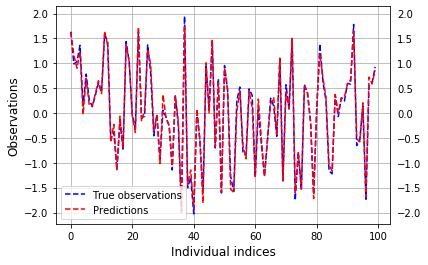

In [13]:
# plot results
Y_pred_kernel = kernel_ridge_regressor.predict(X_test)
plt.plot(Y_test,linestyle = "dashed",color="blue", label= "True observations")
plt.plot(Y_pred_kernel,linestyle = "dashed",color="red", label="Predictions")
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Individual indices', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

### <font color=darkorange> 2. Random forests for simulated time series</font>

Consider a Markov chain, given by $X_0 = x_0$ for $x_0\in \mathbb{R}^d$ and, for $k\geqslant 0$,

$$
X_{k+1} = \rho X_k + \sigma_X\varepsilon_k\,\,\, [2\pi]\,
$$ 

where $(\epsilon_k)_{k\geqslant 0}$ are i.i.d. standard Gaussian vectors in $\mathbb{R}^d$ $\sim {\sf N}(0,{\bf I}_d)$.

The observation model is

$$ 
Y_k = f(X_k) + \sigma_Y\eta_{k}\,,
$$

where $(\eta_k)_{k\geqslant 0}$ are i.i.d. $\sim N(0,1)$ and

$$
f:\begin{cases}
\mathbb{R}^d\to\mathbb{R}\\
{\bf x} \mapsto \sum_{i=1}^{d}\cos(x_i)
\end{cases}\,.
$$

The objective is to estimate the function $f$ using a training data set to predict the observations associated with the test dataset.

Start with a few imports, in particular the function ``RandomForestRegressor`` of sklearn that enables to apply the random forest algorithm in python.

In [14]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Define a function that takes as input the size $d$ of the vector $x_0$, the size $n$ of the dataset, the noise levels $\sigma_X$ of the autoregressive model and $\sigma_Y$ of the observed values and the parameter $\rho$ in the autoregressive model.

The function outputs data following the model described above.

In [16]:
# function to sample a dataset 
def sample_data_ar(rho,sigmax,sigmay,n,d):
    X       = np.zeros(shape=(n,d))
    Y       = np.zeros(n)
    epsilon = np.random.normal(loc=0,scale=1,size = X.shape)
    eta     = np.random.normal(loc=0,scale=1,size = n)
    Y[0]    = np.sum(np.cos(X[0,:])) + sigmax*eta[0]
    for k in range(1,n):
        X[k,:] = (rho*X[k-1,:] + sigmax*epsilon[k,:])%(2*np.pi)
        Y[k]   = np.sum(np.cos(X[k,:])) + sigmay*eta[k]
    return X, Y

In [17]:
# set parameters
n = 2000
d = 4

rho    = 0.1
sigmax = 0.1 
sigmay = 0.01 

Matrices X and Y containing data simulated according to the observation model described above may now be computed.

In [18]:
# sample data  
X, Y = sample_data_ar(rho,sigmax,sigmay,n,d)

To evaluate different algorithms, the dataset is decomposed into training and test data.
In this type of time series analysis, the training data are the first values of $Y_k$ and the test are the last one. This corresponds to situations where one wants to predict future values of $Y$ given historical data.
This is somehow different form the i.i.d. case where taining and test data are chosen randomly using the function ``sklearn.model_selection.train_test_split``

In [19]:
# split variables and observations, using 90% of the data set to estimate f 
import pandas as pd
df = pd.DataFrame(data = X, columns = ['X1', 'X2', 'X3', 'X4'])
df['Y'] = Y

nb_data_train = int(0.95*n)
nb_diff       = n-nb_data_train
df.head()
X_train = df.iloc[0:nb_data_train,:-1] 
X_test  = df.iloc[-nb_diff:,0:-1]
X_train.head()
Y_train = df.iloc[0:nb_data_train,-1] 
Y_test  = df.iloc[-nb_diff:,-1]

A first random forest prediction can be performed. 
``rf`` is the random forest function of sklearn when the number of trees in the forest is set to ``n\_trees``.
The forest is estimated using the training data ``X\_train`` and ``Y\_train`` and the values of $Y$ in the test set are compared to those predicted by the algorithm.
The mean-squared error between these quantities is also displayed.

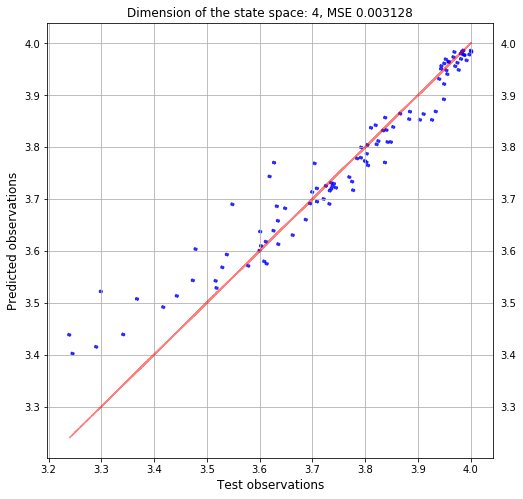

In [20]:
# number of trees in the forest for an elementary random forest estimate
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)

plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf,linestyle = "dashed", color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='red', linestyle = 'dashed', alpha = 0.5)
plt.xlabel('Test observations', fontsize=12)
plt.ylabel('Predicted observations', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')

The predictions seem reasonable $but$ it may be that these predictions are very accurate at first and then that the errors accumulate over time.
To test if this is the case, plot the values of $Y$ in the test set (true and predicted) as functions of the time from the last training time.

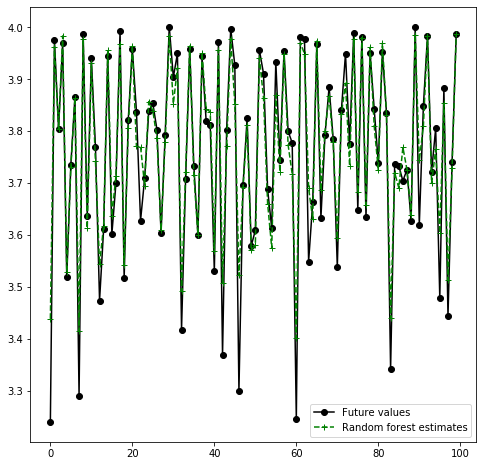

In [21]:
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

To improve this first prediction, the different parameters of the random forest algorithm may be tuned. For example, an increase of the number of trees in the forest reduced the varaince of the Monte Carlo estimate.

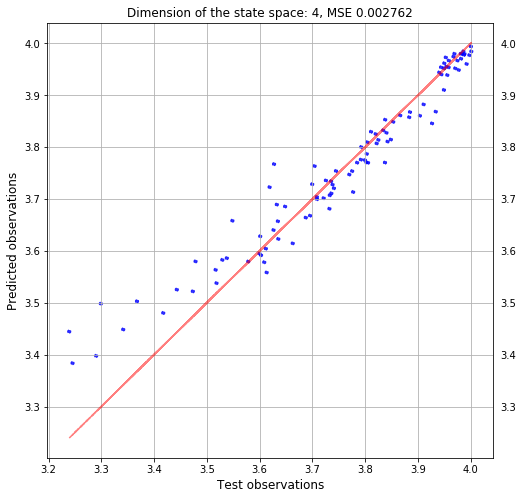

In [22]:
# number of trees in the forest
n_trees = 500
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)


plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf,linestyle = "dashed", color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='red', linestyle = 'dashed', alpha = 0.5)
plt.xlabel('Test observations', fontsize=12)
plt.ylabel('Predicted observations', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')

Note that this increases substancially the computational time although predictions seem equally relevant.

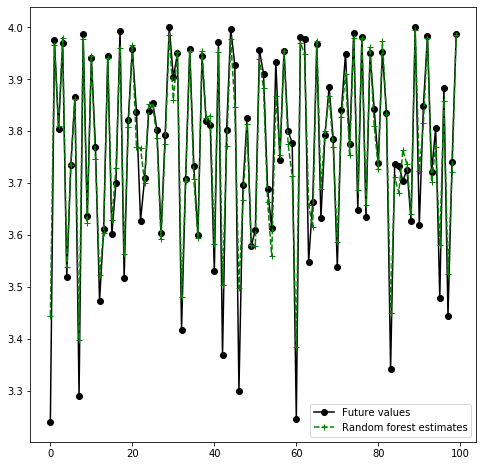

In [23]:
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

The objective is now to improve the algorithm using a cross-validation scheme to estimate the best value of these parameters. It is useful to look at the parameters used by default in the algorithm here:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Set a grid of parameters that will be tested by the cross-validation procedure.

In [24]:
# with RandomizedSearchCVCreate, a grid of tuning parameters is built
# then a random search will be performed to test which parameter values yield the best 
# random forest estimate (see below).
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features is the number of dimension considered to select the best split (the dimension along which a cell is cut)
max_features = ['log2', 'sqrt']
# The maximum depth of the tree corresponds to the maximum number of levels of the tree. 
# If not given, splits are performed until all cells contain less than min_samples_split samples.
max_depth = np.arange(5,100,5)
# min_samples_split is the minimum number of samples in a cell to allow a split.
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# A split is considered in the tree if it leaves at least min_samples_leaf training samples in each 
# subcell obtained after the spliting process.
min_samples_leaf = [1, 2, 3, 4]
# if bootstrap is true all the training dataset is used to build each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]),
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Exploring all parameters combinations in this grid would be computationally prohibitive. 
An efficient alternative is to compare parameters chosen at random in the grid.

In [25]:
rf = RandomForestRegressor()
# Random search among  all parameters (the number of possible combination is given. It is not a complete grid search !!!). 
# search across n_iter = 10 different combinations with a default 3-fold cross validation.
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=10, n_jobs = -1)

rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    8.9s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    9.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   11.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   14.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   14.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [26]:
# display the best parameters
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [27]:
# build the best explored random forest
best_random = rf_random.best_estimator_
y_pred_rf = best_random.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)

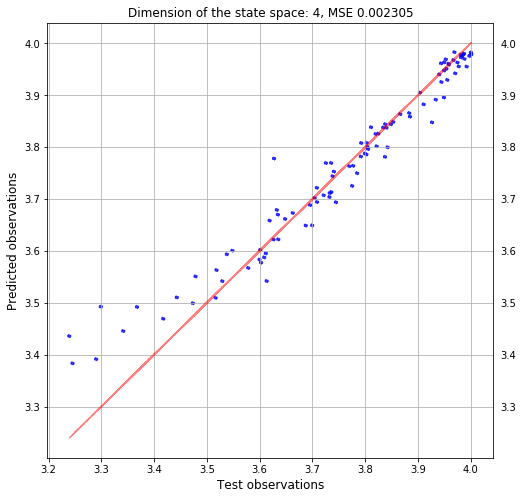

In [28]:
plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf,linestyle = "dashed", color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='red', linestyle = 'dashed', alpha = 0.5)
plt.xlabel('Test observations', fontsize=12)
plt.ylabel('Predicted observations', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')

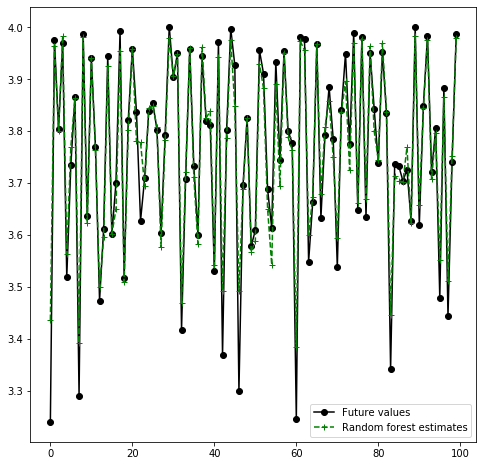

In [29]:
# compute predictions usting test data and associated mean square error
y_pred_rf = rf_random.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

### <font color=darkorange> 3. Random forests for real data - Brazilian inflation prediction </font>

In [35]:
# In this section, random forests are used to predic the Brazilian inflation based on
# many observed variables, see https://github.com/gabrielrvsc/HDeconometrics/
df = pd.read_csv('./BRinf.txt')
df.head()

,Unnamed: 0,Brazil CPI IPCA MoM,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
0,2003-01-31,2.25,2.33,2.17,5.816,2.29,11.56,25422.0,-359,-1.47,...,0.80,0.68,4.0000,1.96,3.8416,0.18,1.3225,1.15,1.3225,0.24
1,2003-02-28,1.57,2.28,1.59,4.351,2.42,10.95,25163.0,-303,-1.21,...,0.68,0.48,2.5600,1.60,2.5600,0.26,0.7569,0.91,0.8281,0.27
2,2003-03-31,1.23,1.53,1.66,4.593,1.58,9.58,24960.0,115,-0.35,...,0.55,0.50,0.8836,0.93,0.8649,0.13,0.4900,0.73,0.5329,0.17
3,2003-04-30,0.97,0.92,0.41,1.173,1.24,8.88,25284.0,93,-0.15,...,0.45,0.78,1.0000,0.97,0.9409,0.14,0.2500,0.52,0.2704,0.18
4,2003-05-31,0.61,-0.26,-0.67,-1.860,0.02,8.22,24785.0,285,-0.47,...,0.60,0.43,0.2500,0.50,0.2500,0.10,0.3025,0.55,0.3025,0.15


In [36]:
# number of observations, number of variables
df.shape

(156, 93)

The function ``pandas.DataFrame.corr`` may be used to compute the pairwise correlations between columns (variables and inflation). These correlations can be displayed using ``sns.heatmap`` to highlight highly correlated variables (and those likely to have an impact on the inflation).

See ``feature_importances_`` below for a first try at (relevant) variable selection.

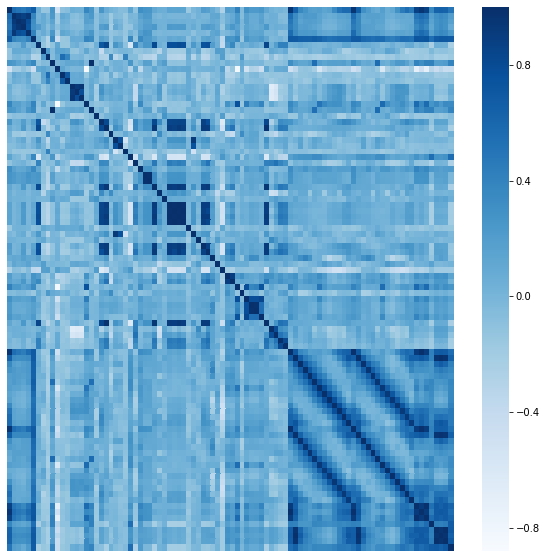

In [37]:
import seaborn as sns
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, xticklabels = False, yticklabels = False, cmap = 'Blues', ax = ax)

In [38]:
corr.head()

,Brazil CPI IPCA MoM,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,CNI Brazil Manufacture Industr,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
Brazil CPI IPCA MoM,1.000000,0.564057,0.513079,0.472865,0.548028,0.666126,0.051693,-0.138035,-0.128571,0.265466,...,0.548735,0.468353,0.876131,0.960011,0.877122,0.378376,0.632513,0.646564,0.631671,0.500115
FGV Brazil General Prices IGP-,0.564057,1.000000,0.931098,0.875071,0.937050,0.383307,0.015717,0.091837,-0.013777,0.234420,...,0.099243,0.118357,0.496675,0.557056,0.501341,0.198352,0.298803,0.345757,0.311183,0.206675
FGV Brazil General Prices IGP-.1,0.513079,0.931098,1.000000,0.950262,0.792862,0.322426,0.030985,0.083818,0.004757,0.151959,...,0.093295,0.096065,0.428282,0.487584,0.436533,0.161159,0.279579,0.324037,0.288390,0.164378
FGV Brazil General Prices IGP-.2,0.472865,0.875071,0.950262,1.000000,0.735705,0.301127,0.208221,0.073154,-0.067722,0.075466,...,0.088300,0.119306,0.360302,0.451189,0.367995,0.125552,0.276022,0.327440,0.280982,0.096484
FGV Brazil General Prices IGP-.3,0.548028,0.937050,0.792862,0.735705,1.000000,0.411856,-0.002718,0.080790,-0.021884,0.248427,...,0.111940,0.138191,0.499192,0.569468,0.507088,0.183621,0.316816,0.356699,0.330572,0.228943


In [39]:
nb_data_train = 140
nb_diff       = df.shape[0]-nb_data_train
# inflation observations
Y_train = df.iloc[0:nb_data_train,1] 
Y_test  = df.iloc[-nb_diff:,1] 
Y_test.head()

140    0.57
141    0.42
142    0.51
143    0.78
144    1.24
Name: Brazil CPI IPCA MoM, dtype: float64

In [40]:
# other variables
X_train = df.iloc[0:nb_data_train,2:] 
X_test  = df.iloc[-nb_diff:,2:] 
X_test.head()

,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,CNI Brazil Manufacture Industr,CNI Brazil Manufacture Industr.1,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
140,0.20,0.02,0.110,0.31,6.34,38551.0,580,-0.22,-0.1,81.8,...,0.35,0.41,0.1849,0.43,0.1849,0.04,0.2500,0.49,0.2401,0.05
141,0.28,0.59,3.158,0.02,6.38,38798.0,-266,-0.63,0.3,82.3,...,0.40,0.53,0.2500,0.50,0.2500,0.04,0.3249,0.58,0.3364,0.05
142,0.98,1.14,6.098,0.82,6.57,40100.0,61,-0.76,-0.6,82.6,...,0.52,0.64,0.3025,0.59,0.3481,0.05,0.5476,0.72,0.5184,0.08
143,0.62,0.38,2.089,0.98,6.67,40950.0,327,-1.48,-0.1,82.0,...,0.64,0.71,0.4900,0.75,0.5625,0.05,0.9409,0.97,0.9409,0.12
144,0.76,0.67,3.672,0.42,7.01,39673.0,-773,-0.82,-0.2,78.6,...,0.72,0.69,1.9600,1.18,1.3924,0.11,1.0201,0.99,0.9801,0.16


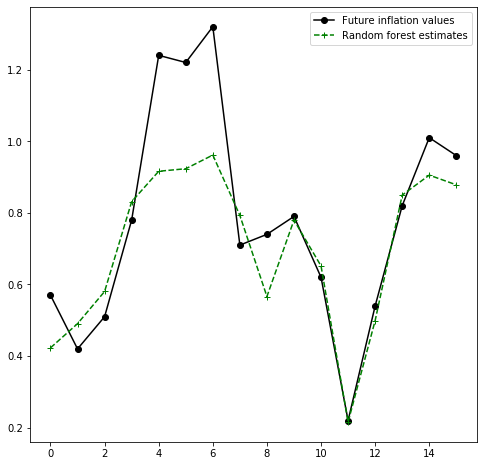

In [41]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

Many variables are used for the inflation prediction while very few observations are available.
Selecting the most valuable variables is an alternative which may be achieved using ``rf.feature_importances_``

Text(0.5, 1.0, 'Feature importances')

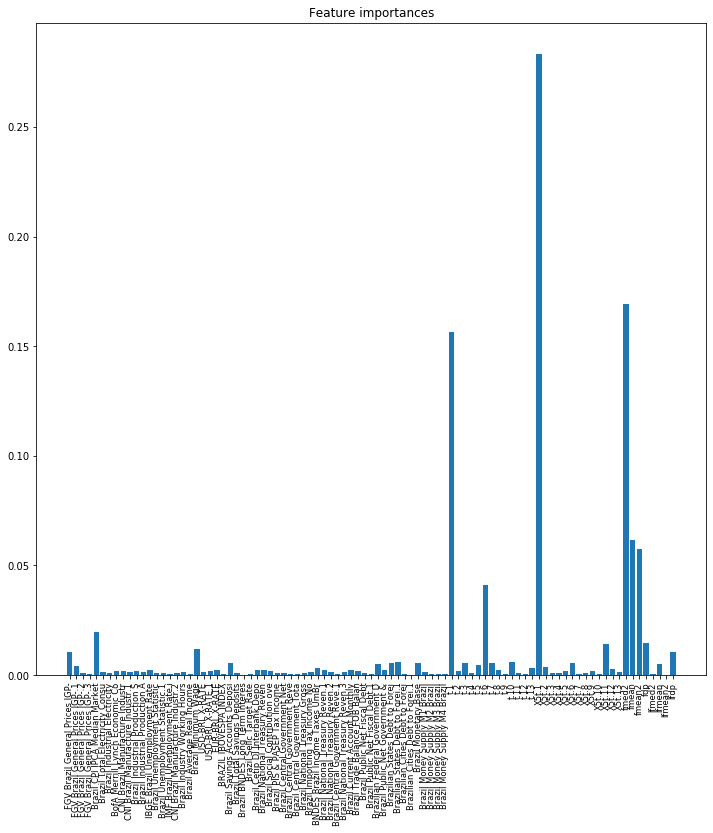

In [42]:
plt.figure(1,figsize=(12,12))
plt.bar(list(df)[2:93],rf.feature_importances_,align='center')
plt.xticks(range(len(list(df)[2:93])),list(df)[2:93],rotation=90,size='small')
plt.title('Feature importances')

``RandomForestClassifier`` and ``RandomForestRegressor`` use the gini importance mechanism as a measure of the fetaures importance. The mean decrease in impurity importance of a feature is computed, see https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf

In [43]:
# collect the indices of the features with highest importance.
nb_features_to_keep = 10
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train.iloc[:,ind]

,Brazil Minimum Wage,X5t.11,fdp,Brazil CPI IPCA Median Market,t.6,fmean2,fmean,t.1,fmed2,X5t.1
0,200,0.81,0.18,11.56,0.82,3.8416,1.96,2.00,4.0000,2.10
1,200,0.82,0.26,10.95,1.47,2.5600,1.60,1.60,2.5600,1.65
2,200,0.68,0.13,9.58,0.80,0.8649,0.93,0.94,0.8836,0.95
3,200,0.63,0.14,8.88,0.60,0.9409,0.97,1.00,1.0000,1.10
4,240,0.45,0.10,8.22,0.58,0.2500,0.50,0.50,0.2500,0.50
...,...,...,...,...,...,...,...,...,...,...
135,724,0.64,0.07,6.17,0.39,0.6084,0.78,0.80,0.6400,0.84
136,724,0.46,0.05,6.00,0.50,0.2025,0.45,0.45,0.2025,0.43
137,724,0.54,0.06,5.96,0.57,0.1156,0.34,0.35,0.1225,0.33
138,724,0.46,0.07,5.85,0.64,0.0196,0.14,0.15,0.0225,0.15


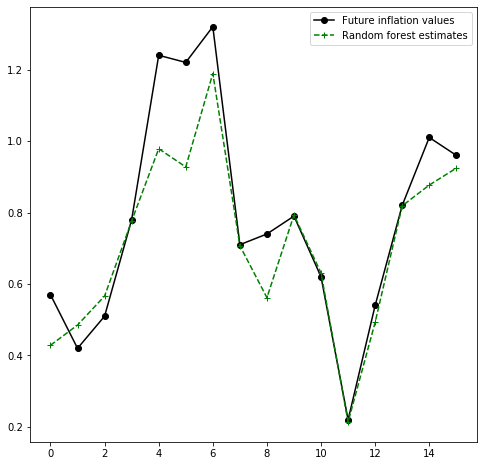

In [44]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

<img src="./PCA_cor.png" width="500" height="700">

In [45]:
# plot the MSE as a function of the numbers of variables used to estimate the function f
d_max = 60
MSE   = []
rf    = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)
for d in range(2,d_max): 
    rfd = RandomForestRegressor(n_estimators = n_trees)
    ind = rf.feature_importances_.argsort()[-d:]
    rfd.fit(X_train.iloc[:,ind],Y_train)
    # compute predictions usting test data and associated mean square error
    y_pred_rf = rfd.predict(X_test.iloc[:,ind])
    MSE = np.append(MSE,mean_squared_error(Y_test,y_pred_rf))

Text(0, 0.5, 'Mean square error on the test data set')

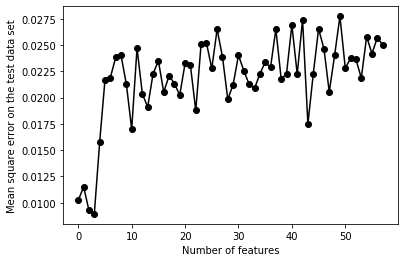

In [46]:
#plt.figure(1,figsize=(8,8))
plt.plot(MSE,marker='o',color='k')
plt.xlabel('Number of features')
plt.ylabel('Mean square error on the test data set')

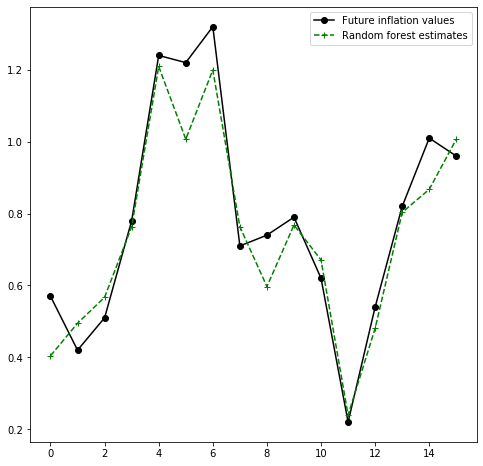

In [47]:
# collect the indices of the features with highest importance.
nb_features_to_keep = 4
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train.iloc[:,ind]
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

In [ ]:
# you may add here a cross validation procedure using RandomizedSearchCV or GridSearchCV
# to select the best parameters (and compare the mean square error with what you obtain above).